In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from matplotlib.colors import ListedColormap
import random

%matplotlib inline

In [2]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [3]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction

In [4]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [5]:
# Расчет критерия Энтропия

def entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 0
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p * np.log2(p)
        
    return impurity

In [6]:
# Расчет качества

def quality(left_labels, right_labels, current_value, criterion = 'gini'):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    if criterion == 'entropy':
        new_value = current_value - p * entropy(left_labels) - (1 - p) * entropy(right_labels)
    else:
        new_value = current_value - p * gini(left_labels) - (1 - p) * gini(right_labels)
    return new_value

In [7]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [8]:
def find_best_split(data, labels, limit_leafs = 0, limit_features = -1, criterion = 'gini'):
    
    #  minimal leafs in node
    if limit_leafs:
        min_leaf = limit_leafs
    else:
        min_leaf = 5
    
    if criterion == 'entropy':
        current_value = entropy(labels)
    else:
        current_value = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    #  limit features
    if limit_features != -1:
        if limit_features < data.shape[1]:
            n_features = limit_features
        else:
            n_features = data.shape[1]
    else:
        n_features = data.shape[1]
        
    # # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  ignore nodes with leafs number less than limit
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                #print(f'True length - {len(true_data)}/nFalse length - {len(false_data)}')
                continue
            
            current_quality = quality(true_labels, false_labels, current_value, criterion)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [9]:
def build_tree(data, labels, limit_leafs = 0, limit_depth = -1, limit_features = 0, criterion = 'gini'):
    # tree depth control
    depth = limit_depth

    quality, t, index = find_best_split(data, labels, limit_leafs+1, limit_features, criterion)
    
    if depth:
        depth -= 1
    else:
        return Leaf(data, labels)

    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, limit_leafs, depth, limit_features, criterion)
    false_branch = build_tree(false_data, false_labels, limit_leafs, depth, limit_features, criterion)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [10]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [11]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [12]:
# предсказание голосованием деревьев
def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то, за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [13]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [14]:
random.seed(42)
 
def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]            
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [15]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [16]:
def random_forest(data, labels, n_trees, limit_leafs = 0, limit_depth = -1, limit_features = 0, criterion = 'gini'):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels, limit_leafs, limit_depth, limit_features, criterion))
        
    return forest

In [17]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

In [18]:
def data_plot(trees, train_data, test_data, current_forest):

    plt.figure(figsize = (16, 7))
    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(current_forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    train_answers = tree_vote(current_forest, train_data)
    train_accuracy = accuracy_metric(train_labels, train_answers)
    plt.title(f'Train accuracy={train_accuracy:.2f} for forest with {trees} trees')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    test_answers = tree_vote(current_forest, test_data)
    test_accuracy = accuracy_metric(test_labels, test_answers)
    plt.title(f'Test accuracy={test_accuracy:.2f} for forest with {trees} trees')
    plt.show()

## Урок 5. Случайный лес
1. Сформировать с помощью sklearn.make_classification датасет из 1000 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50, 100, 200 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote). Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.
2. Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.*

### 1. Сформировать с помощью sklearn.make_classification датасет из 1000 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50, 100, 200 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote). Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

In [19]:
# data preparation
classification_data, classification_labels = datasets.make_classification(n_samples=1000, n_features = 2, 
                                                                          n_informative = 2, n_classes = 2, 
                                                                          n_redundant=0, n_clusters_per_class = 1, 
                                                                          random_state=13, shuffle=True)

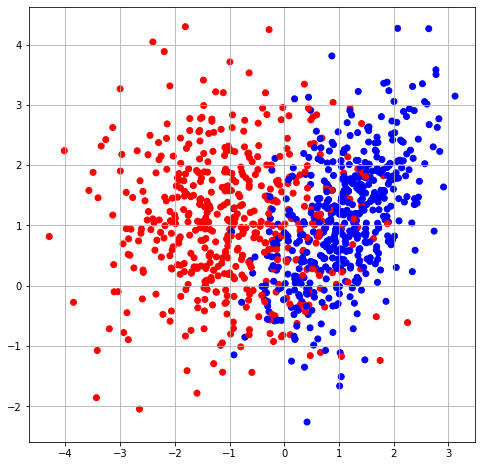

In [20]:
# generated data visualization
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])


plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)
plt.grid(True)

In [21]:
# Разобьем выборку на обучающую и тестовую
from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [22]:
# Построим дерево по обучающей выборке
min_leafs = 12
max_depth = 5
max_features = 9
n_trees = [1, 3, 10, 50, 100, 200]
forests = []
for trees in n_trees:
    current_forest = random_forest(train_data, train_labels, trees, min_leafs, max_depth, max_features)
    forests.append(current_forest)

#### Data visualization

<ipython-input-18-9031cc15579b>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-18-9031cc15579b>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


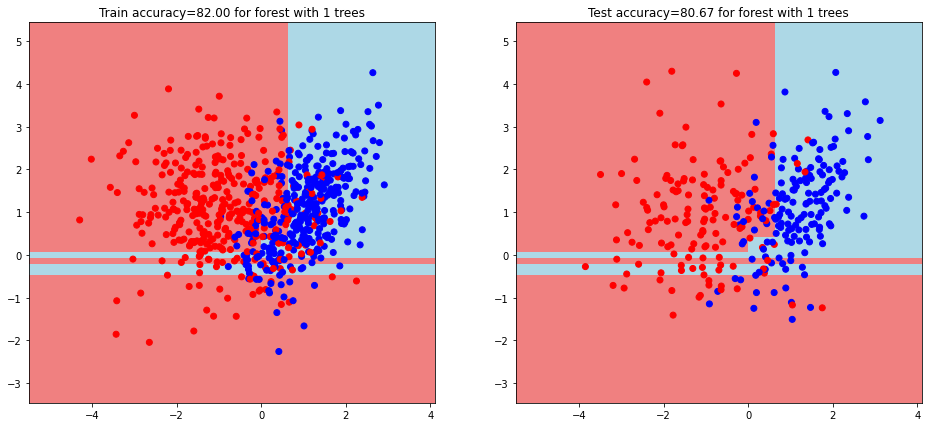

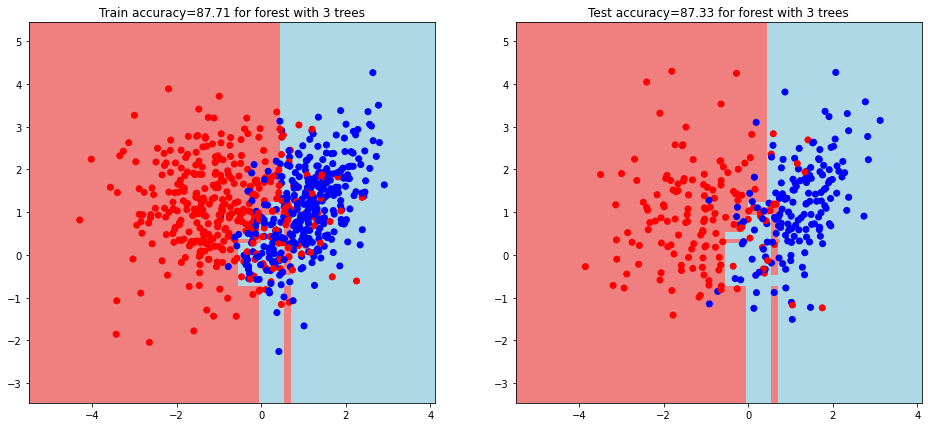

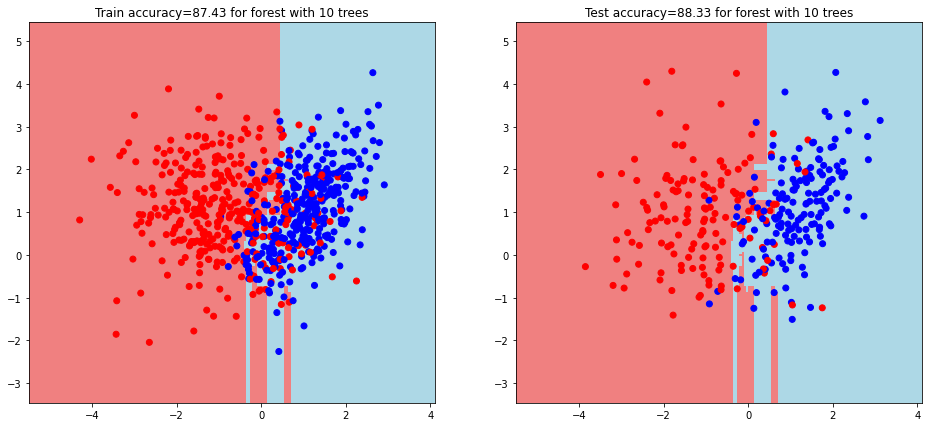

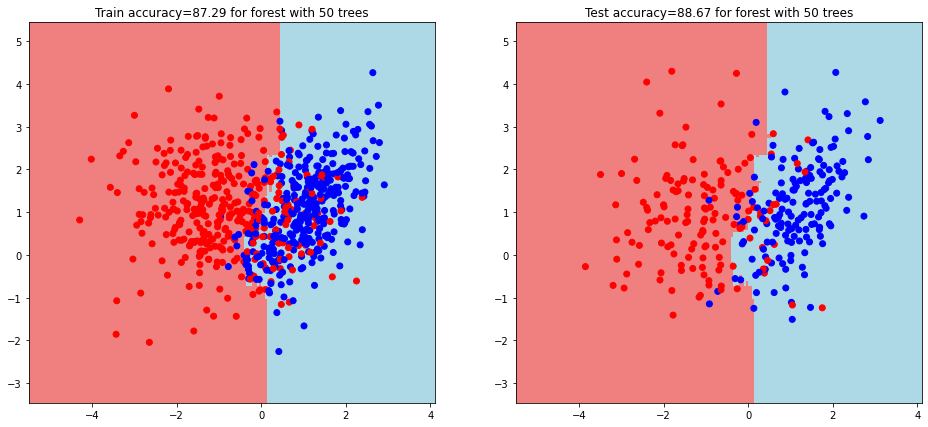

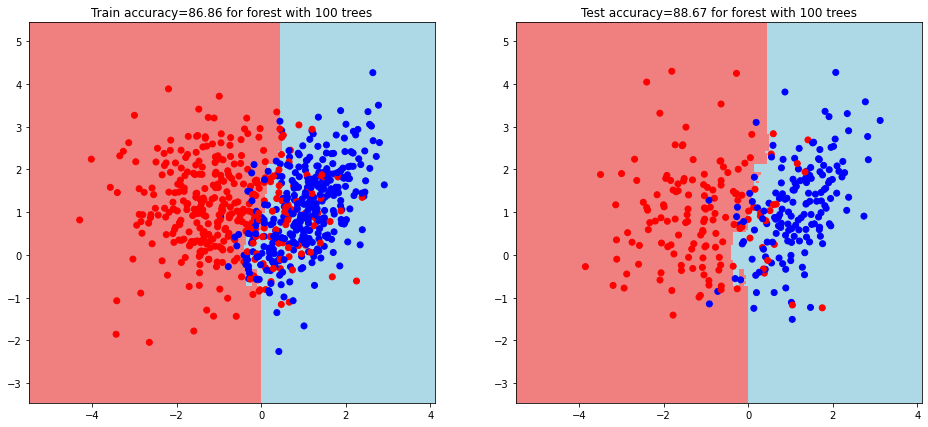

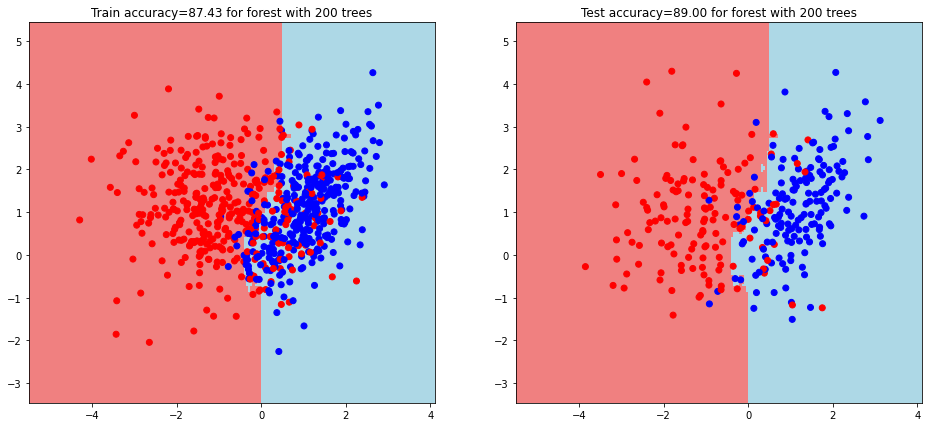

In [23]:
for trees, current_forest in zip(n_trees, forests):
    data_plot(trees, train_data, test_data, current_forest)

In [24]:
#print_tree(my_tree)
# Получим ответы для обучающей выборки 
train_answers = [tree_vote(current_forest, train_data) for current_forest in forests]
train_accuracy = [round(accuracy_metric(train_labels, train_answer),3) for train_answer in train_answers]
# И получим ответы для тестовой выборки
test_answers = [tree_vote(current_forest, test_data) for current_forest in forests]
test_accuracy = [round(accuracy_metric(test_labels, test_answer),3) for test_answer in test_answers]

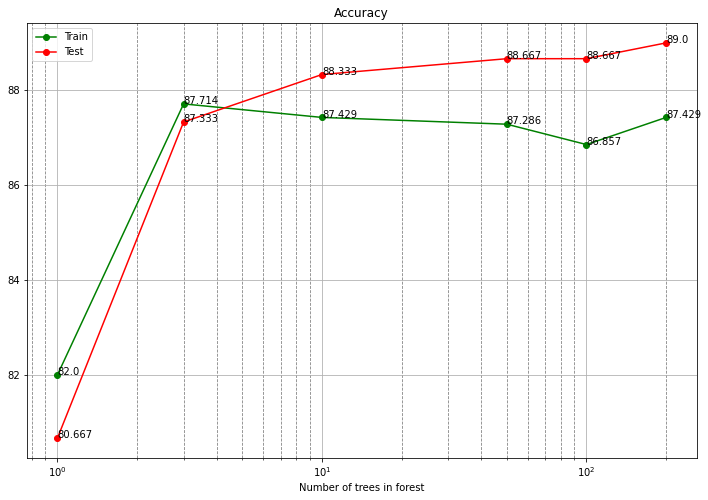

In [25]:
plt.figure(figsize = (12, 8))
light_colors = ListedColormap(['lightcoral', 'lightblue'])
plt.plot(n_trees, train_accuracy, color = 'green', label = 'Train', marker = 'o')
for i,j in zip(n_trees,train_accuracy):
    plt.annotate(str(j),xy=(i,j))
plt.plot(n_trees, test_accuracy, color = 'red', label = 'Test', marker = 'o')
for i,j in zip(n_trees,test_accuracy):
    plt.annotate(str(j),xy=(i,j))
plt.xscale('log')
plt.title(f'Accuracy')
plt.xlabel(f'Number of trees in forest')
plt.legend()
plt.grid(True)
plt.grid(b=True, which='minor', color='grey', linestyle='--')

In [26]:
print(f'Минимальное количество листьев - {min_leafs}\nМаксимальная глубина дерева - {max_depth}\n')

Минимальное количество листьев - 12
Максимальная глубина дерева - 5



Для выбранных параметров увеличение количества деревьев более 50 практически не ведет к улучшению точности и усложнению гиперплоскости. Алгоритм не переобучился, но и улучшение точности незаметно при значительном усложнении.

### 2. Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.*